In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import csv

In [3]:
# load csv into pandas dataFrame
df = pd.read_csv('EuCitiesTemperatures.csv')

#TESTING/EXECUTING
df.head

<bound method NDFrame.head of           city         country  population   EU coastline  latitude  \
0      Elbasan         Albania        2.90   no       yes     41.12   
1      Andorra         Andorra        0.07   no        no     42.50   
2    Innsbruck         Austria        8.57  yes        no       NaN   
3         Graz         Austria        8.57  yes        no     47.08   
4         Linz         Austria        8.57  yes        no     48.32   
..         ...             ...         ...  ...       ...       ...   
208  Edinburgh  United Kingdom       65.11  yes       yes     55.95   
209     Exeter  United Kingdom       65.11  yes       yes     50.70   
210  Inverness  United Kingdom       65.11  yes       yes       NaN   
211    Glasgow  United Kingdom       65.11  yes       yes     55.87   
212    Swansea  United Kingdom       65.11  yes       yes     51.63   

     longitude  temperature  
0        20.08        15.18  
1         1.52          NaN  
2        11.41         4.54

In [14]:
#PREPROCESSING 1: Fill in the missing latitude and longitude values by calculating the average for that country. Round the average to 2 decimal places

df['latitude'] = df['latitude'].fillna(df.groupby('country')['latitude'].transform(lambda x: round(x.mean(), 2)))

df['longitude'] = df['longitude'].fillna(df.groupby('country')['longitude'].transform(lambda x: round(x.mean(), 2)))


##TESTING/EXECUTING
import csv 
with open('Cleaned_EuCitiesTemperatures.csv', 'w', newline='') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(df.columns)
    for row in df.itertuples(index=False):
        writer.writerow(row)

In [5]:
#PREPROCESSING 2:  Find out the subset of cities that lie between latitudes 40 to 60 (both inclusive) and longitudes 15 to 30 (both inclusive). 
#Find out which countries have the maximum number of cities in this geographical band. (More than one country could have the maximum number of values.)
# Filter cities in the geographic band
band_df = df[(df['latitude'] >= 40) & (df['latitude'] <= 60) & (df['longitude'] >= 15) & (df['longitude'] <= 30)]

country_counts = band_df['country'].value_counts()
max_count = country_counts.max()
countries_with_max = country_counts[country_counts == max_count]


##TESTING/EXECUTING
countries_with_max


country
Romania    9
Poland     9
Name: count, dtype: int64

In [15]:
#PREPROOCRESSING 3:  Fill in the missing temperature values by the average temperature value of the similar region type. 
#A region type would be a combinaton of whether it is in EU (yes/no) and whether it has a coastline (yes/no).
#For example, if we have a missing temperature value for Bergen, Norway, which is not in the EU but lies on the coast, 
#we will fill it with the average temperature of cities with EU='no' and coastline='yes')

df['RegionType'] = df['EU'].astype(str) + '+' + df['coastline'].astype(str)

region_avg_temp = df.groupby('RegionType')['temperature'].mean()

def fill_temp(row):
    if pd.isna(row['temperature']):
        return region_avg_temp[row['RegionType']]
    return row['temperature']

df['temperature'] = df.apply(fill_temp, axis=1)


# TESTING/EXECUTING

print("Missing temperatures left:", df['temperature'].isna().sum())

Missing temperatures left: 0


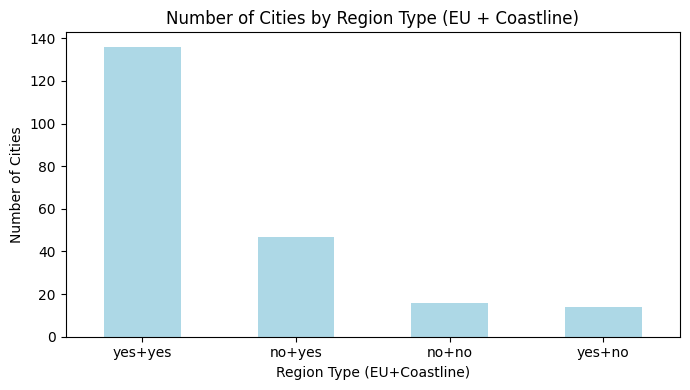

In [8]:
#VISUALIZATION 1 Plot a bar chart for the number of cities belonging to each of the regions described in Preprocessing/Analysis #3 above
# Count of cities per region type (Coastline yes/no)
import matplotlib.pyplot as plt
region_counts = df['RegionType'].value_counts()

plt.figure(figsize=(7, 4))
region_counts.plot(kind='bar', color='lightblue')

plt.title('Number of Cities by Region Type (EU + Coastline)')
plt.xlabel('Region Type (EU+Coastline)')
plt.ylabel('Number of Cities')
plt.xticks(rotation=0)


#TESTING/EXECUTING
plt.tight_layout()
plt.show()

In [ ]:
#visualization 2 Plot a scatter plot of latitude (y-axis) v/s longitude (x-axis) values to get a map-like visual of the cities under consideration. 
#All the cities in the same country should have the same color
# Scatter plot of latitude vs longitude, colored by country

band_df = df[
    (df['latitude'] >= 40) & (df['latitude'] <= 60) &
    (df['longitude'] >= 15) & (df['longitude'] <= 30)
]
# 
plt.figure(figsize=(10, 6))


countries = band_df['country'].unique()
for country in countries:
    country_df = band_df[band_df['country'] == country]
    plt.scatter(country_df['longitude'], country_df['latitude'], label=country, s=20)

plt.title('Cities Between Latitude 40–60 and Longitude 15–30 (Color by Country)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#do we need a legend to list countries
#ADD LEGEND JUST IN CASE
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)
plt.grid(True)

##TESTING/EXECUTING
plt.tight_layout()
plt.show()

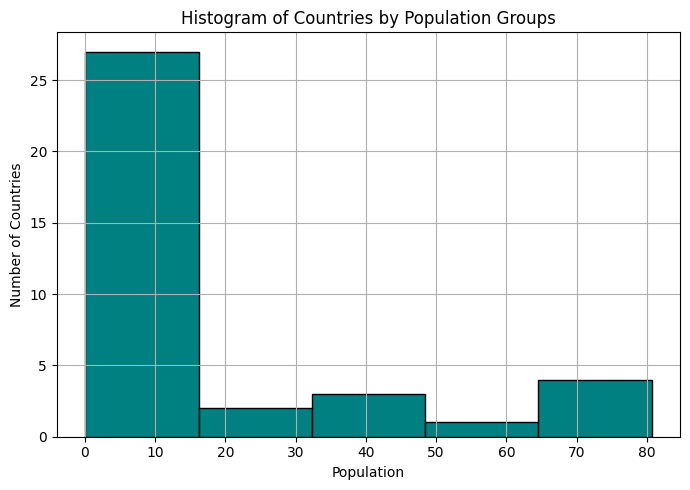

In [10]:
#visualization 3 The population column contains values unique to each country. So two cities of the same country will show the same population value. 
#Plot a histogram of the number of countries belonging to each population group: split the population values into 5 bins (groups)

pop_df = df.drop_duplicates(subset='country')

plt.figure(figsize=(7, 5))
plt.hist(pop_df['population'], bins=5, edgecolor='black', color='teal')

plt.title('Histogram of Countries by Population Groups')
plt.xlabel('Population')
plt.ylabel('Number of Countries')
plt.grid(True)

#TESTING/EXECUTING
plt.tight_layout()
plt.show()

In [ ]:
#visualization 4 Plot subplots (2, 2), with proper titles, one each for the region types described in Preprocessing/Analysis #3 above.
#Each subplot should be a scatter plot of Latitude (y-axis) vs. City (x-axis), where the color of the plot points should be based on the temperature values:
#‘red’ for temperatures above 10, ‘blue’ for temperatures below 6 and ‘orange for temperatures between 6 and 10 (both inclusive). 
#For each subplot, set xticks to an array of numbers from 0 to n-1 (both inclusive), where n is the total number of cities in each region type. This represents each city as a number between 0 and n-1.
# Create temperature color categories
def get_temp_color(temp):
    if temp > 10:
        return 'red'
    elif temp < 6:
        return 'blue'
    else:
        return 'orange'

df['TempColor'] = df['temperature'].apply(get_temp_color)

region_groups = df.groupby('RegionType')

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

region_keys = sorted(region_groups.groups.keys())

for idx, region in enumerate(region_keys):
    group = region_groups.get_group(region).reset_index(drop=True)
    city_indices = list(range(len(group)))  
    colors = group['TempColor']

    axes[idx].scatter(city_indices, group['latitude'], c=colors)
    axes[idx].set_title(f"Region Type: EU={region.split('+')[0]}, Coastline={region.split('+')[1]}")
    axes[idx].set_xlabel("City Index")
    axes[idx].set_ylabel("Latitude")
    axes[idx].set_xticks(city_indices)
    axes[idx].grid(True)


#TESTING/EXECUTING
plt.tight_layout()
plt.show()